# Transfer Learning

In this notebook, you'll learn how to use pre-trained networks to solved challenging problems in computer vision. Specifically, you'll use networks trained on [ImageNet](http://www.image-net.org/) [available from torchvision](http://pytorch.org/docs/0.3.0/torchvision/models.html). 

ImageNet is a massive dataset with over 1 million labeled images in 1000 categories. It's used to train deep neural networks using an architecture called convolutional layers. I'm not going to get into the details of convolutional networks here, but if you want to learn more about them, please [watch this](https://www.youtube.com/watch?v=2-Ol7ZB0MmU).

Once trained, these models work astonishingly well as feature detectors for images they weren't trained on. Using a pre-trained network on images not in the training set is called transfer learning. Here we'll use transfer learning to train a network that can classify our cat and dog photos with near perfect accuracy.

With `torchvision.models` you can download these pre-trained networks and use them in your applications. We'll include `models` in our imports now.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

print('Files in Drive:')
!ls /content/drive/'My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Files in Drive:
'Colab Notebooks'   CommandLine.ipynb   PyTorch-Exercises   test


In [1]:
cd /content/drive/My Drive/PyTorch-Exercises/Cat-Dog-Classifier/

/content/drive/My Drive/PyTorch-Exercises/Cat-Dog-Classifier


In [2]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [3]:
#!pip install -U pillow
import PIL
print(PIL.PILLOW_VERSION)

5.4.0


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

Most of the pretrained models require the input to be 224x224 images. Also, we'll need to match the normalization used when the models were trained. Each color channel was normalized separately, the means are `[0.485, 0.456, 0.406]` and the standard deviations are `[0.229, 0.224, 0.225]`.

In [0]:
data_dir = 'Cat_Dog_data'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(254),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)


>**Exercise:** Train a pretrained models to classify the cat and dog images. Try ResNet, it's also a good model to try out first. Make sure you are only training the classifier and the parameters for the features part are frozen.

In [7]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 98772421.76it/s]


This model is built out of two main parts, the features and the classifier. The features part is a stack of convolutional layers and overall works as a feature detector that can be fed into a classifier. The classifier part is a single fully-connected layer `(classifier): Linear(in_features=2048, out_features=1000)`. This layer was trained on the ImageNet dataset, so it won't work for our specific problem. That means we need to replace the classifier, but the features will work perfectly on their own. In general, I think about pre-trained networks as amazingly good feature detectors that can be used as the input for simple feed-forward classifiers.

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512,2),
                           nn.LogSoftmax(dim=1))

With our model built, we need to train the classifier. However, now we're using a **really deep** neural network. If you try to train this on a CPU like normal, it will take a long, long time. Instead, we're going to use the GPU to do the calculations. The linear algebra computations are done in parallel on the GPU leading to 100x increased training speeds. It's also possible to train on multiple GPUs, further decreasing training time.

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

From here, I'll let you finish training the model. The process is the same as before except now your model is much more powerful. You should get better than 95% accuracy easily.

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
model.fc = classifier

In [0]:
import time
torch.cuda.is_available()

True

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
epochs = 1
steps = 0
running_loss = 0
print_every = 40
start = time.time()
for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() 
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
print(f"Total Time: {(time.time() - start)} seconds")

Epoch 1/1.. Train loss: 0.479.. Test loss: 0.231.. Test accuracy: 0.900
Epoch 1/1.. Train loss: 0.285.. Test loss: 0.360.. Test accuracy: 0.828
Epoch 1/1.. Train loss: 0.185.. Test loss: 0.144.. Test accuracy: 0.944
Epoch 1/1.. Train loss: 0.150.. Test loss: 0.101.. Test accuracy: 0.960
Epoch 1/1.. Train loss: 0.162.. Test loss: 0.267.. Test accuracy: 0.889
Epoch 1/1.. Train loss: 0.176.. Test loss: 0.133.. Test accuracy: 0.947
Epoch 1/1.. Train loss: 0.133.. Test loss: 0.092.. Test accuracy: 0.961
Epoch 1/1.. Train loss: 0.077.. Test loss: 0.181.. Test accuracy: 0.924
Epoch 1/1.. Train loss: 0.095.. Test loss: 0.183.. Test accuracy: 0.923
Epoch 1/1.. Train loss: 0.078.. Test loss: 0.085.. Test accuracy: 0.964
Epoch 1/1.. Train loss: 0.146.. Test loss: 0.111.. Test accuracy: 0.957
Epoch 1/1.. Train loss: 0.131.. Test loss: 0.113.. Test accuracy: 0.955
Epoch 1/1.. Train loss: 0.110.. Test loss: 0.082.. Test accuracy: 0.966
Epoch 1/1.. Train loss: 0.102.. Test loss: 0.140.. Test accuracy

In [0]:
def save_checkpoint(model, file):
    check_point_file = file
    model.class_to_idx = train_data.class_to_idx
    
    checkpoint_dict = {
        'arch': 'resnet50',
        'fc': model.fc,
        'class_to_idx': model.class_to_idx, 
        'state_dict': model.state_dict()
    }

    torch.save(checkpoint_dict, check_point_file)
    

file = "resnet50_1epoch.pth"
save_checkpoint(model, file)

In [8]:
def load_checkpoint(file):
  
    device = torch.device("cuda")
    chkpt = torch.load(file)
    model = models.resnet50(pretrained=True)
    model.fc = chkpt['fc']
    model.load_state_dict(chkpt['state_dict'])
    model.class_to_idx = chkpt['class_to_idx']
    model.to(device)
    return model

file = "resnet50_1epoch.pth"
model = load_checkpoint(file)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    #resize with a shortest dimension being 256
    base = 256
    width, height = image.size
    if width <= height:
        new_height = int(float(height/width)*base)
        processed_im = image.resize((base, new_height), Image.ANTIALIAS)
    else:
        new_width = int(float(width/height)*base)
        processed_im = image.resize((new_width,base), Image.ANTIALIAS)
    
    #crop center image
    width, height = processed_im.size   # Get dimensions
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    processed_im = processed_im.crop((left, top, right, bottom))

    #convert values to 0-1
    np_image = np.array(processed_im)/255
    
    #normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = np.divide(np_image-mean, std)
    
    # Move color channels to first dimension (from third dimesion of PIL) as expected by PyTorch
    transposed_im = np_image.transpose((2, 0, 1))
    
    return transposed_im

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    
    image = image.transpose((1, 2, 0))

    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax

In [0]:
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    image = Image.open(image_path)
    processed_im = process_image(image)
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    model.eval()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():   
        #convert from double numpy to torch float type
        torch_im = torch.from_numpy(processed_im).float()
        torch_im.unsqueeze_(0) 
        torch_im = torch_im.to(device)
        #print(type(torch_im))
        
        outputs = model.forward(torch_im)
        ps, idx = outputs.topk(topk)
        ps = ps.cpu()
        ps = np.exp(ps.numpy())
        

        #invert mapping
        inv_map = {v: k for k, v in model.class_to_idx.items()} 
        idx = idx.cpu()
        idx = [inv_map[i] for i in idx.numpy()[0]]
        #classes = [cat_to_name[i] for i in idx]
        print("Probabilites: ", ps[0])
        print("Classes: ", idx)
        #print("Class_names: ", classes)
    
    return ps[0], idx

In [12]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
def view_classifier(img, ps, idx, image_class):
    ''' Function for viewing an image and it's predicted classes.
    '''

    fig, (ax1, ax2) = plt.subplots(figsize=(3.5,8.75), nrows=2)
    imshow(img, ax = ax1)
    ax1.axis('off')
    ax1.set_title(image_class)

    classes = idx
    y_pos = np.arange(len(classes))
    ax2.barh(y_pos, ps, align='center')
    ax2.invert_yaxis()
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(classes, size='large');
    ax2.set_title('Class Probability')
    plt.show()

## Demosntrate Results

Probabilites:  [0.96756923 0.03243075]
Classes:  ['dog', 'cat']


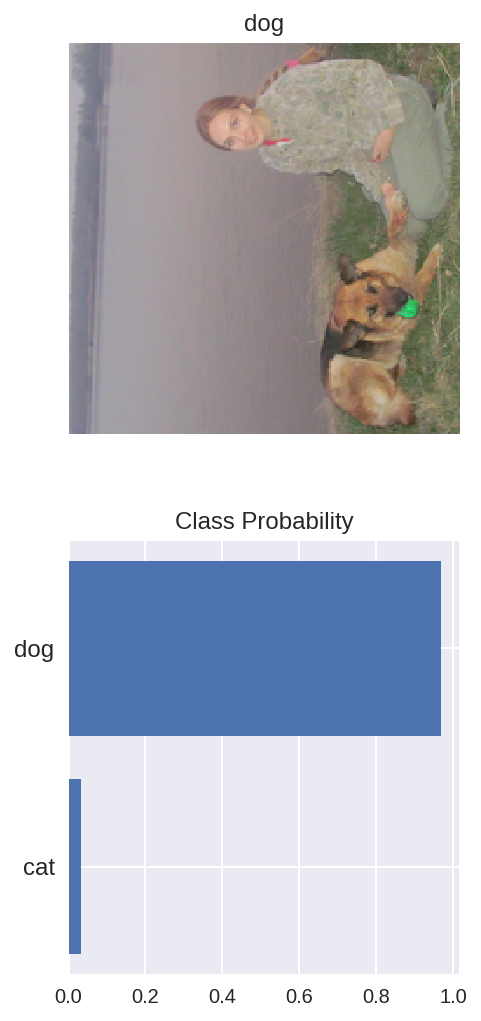

In [14]:
import numpy as np
# TODO: Display an image along with probabilities
image_class = "dog"
#image_path = "Cat_Dog_data/test/"+image_class+"/dog.1001.jpg"
image_path = "Aza1.JPG"

image = Image.open(image_path)
processed_im = process_image(image)

ps, idx = predict(image_path, model, 2)
view_classifier(processed_im, ps, idx, image_class)

In [15]:
ls

Aza1.JPG  Aza3.JPG                  Cat_Dog_data/     __MACOSX/
Aza2.JPG  Cat-Dog-Classifier.ipynb  Cat_Dog_data.zip  resnet50_1epoch.pth


## Check available memory

In [16]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 11.5 GB  | Proc size: 2.3 GB
GPU RAM Free: 10925MB | Used: 516MB | Util   5% | Total 11441MB
